<a href="https://colab.research.google.com/github/banderGlitch/-postgresql-db-management/blob/main/FactoryGuard_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# FactoryGuard AI – Predictive Maintenance Engine

# This project predicts industrial machine failure using sensor data.
# The objective is to detect potential failure 24 hours in advance to reduce downtime cost.

# This is a binary classification problem where:
# 0 → No Failure
# 1 → Machine Failure

In [81]:
!git clone https://github.com/banderGlitch/Infotech.git

Cloning into 'Infotech'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 3), reused 19 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 143.68 KiB | 3.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [82]:
%cd Infotech

/content/Infotech/Infotech/Infotech


In [83]:
!ls

01_eda.ipynb		03_modeling.ipynb  README.md
02_preprocessing.ipynb	archive		   requirements.txt


In [84]:
!pip install xgboost imbalanced-learn shap seaborn

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

plt.style.use('ggplot')

In [86]:
import pandas as pd

url = "https://raw.githubusercontent.com/banderGlitch/Infotech/main/archive/ai4i2020.csv"

df = pd.read_csv(url)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [87]:
# --- Temporal Features (Lag + Rolling) ---

df['Temp_lag1'] = df['Air temperature [K]'].shift(1)
df['Torque_lag1'] = df['Torque [Nm]'].shift(1)

df['Temp_roll_mean'] = df['Air temperature [K]'].rolling(3).mean()
df['Torque_roll_mean'] = df['Torque [Nm]'].rolling(3).mean()

# drop rows created with NaN from lag/rolling- before train-test split
df = df.dropna()

In [88]:
df = df.interpolate() #missing values handling

/tmp/ipython-input-10736/2097226061.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate() #missing values handling


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

plt.style.use('ggplot')

In [90]:
X = df.drop("Machine failure", axis=1)
y = df["Machine failure"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [91]:
from sklearn.linear_model import LogisticRegression

# Identify non-numeric columns that should be dropped for this model
cols_to_drop = ["UDI", "Product ID", "Type"]

# Drop these columns from X_train and X_test
# Using .copy() to avoid SettingWithCopyWarning if these dataframes are used elsewhere
X_train_processed = X_train.drop(columns=cols_to_drop, errors='ignore').copy()
X_test_processed = X_test.drop(columns=cols_to_drop, errors='ignore').copy()

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_processed, y_train)             #modelling

y_pred_log = log_model.predict(X_test_processed)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1940
           1       1.00      0.97      0.98        60

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
# Identify non-numeric columns that should be dropped for this model
cols_to_drop = ["UDI", "Product ID", "Type"]

# Drop these columns from X_train and X_test
# Using .copy() to avoid SettingWithCopyWarning if these dataframes are used elsewhere
X_train_processed = X_train.drop(columns=cols_to_drop, errors='ignore').copy()
X_test_processed = X_test.drop(columns=cols_to_drop, errors='ignore').copy()

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_processed, y_train)

y_pred_rf = rf.predict(X_test_processed)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1940
           1       1.00      0.97      0.98        60

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [93]:
sm = SMOTE(random_state=42)

# Identify non-numeric columns that should be dropped for SMOTE
cols_to_drop = ["UDI", "Product ID", "Type"]

# Drop these columns from X_train before applying SMOTE
X_train_smote_processed = X_train.drop(columns=cols_to_drop, errors='ignore').copy()

X_res, y_res = sm.fit_resample(X_train_smote_processed, y_train)

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

In [95]:
xgb_base = XGBClassifier(
    scale_pos_weight=10,
    random_state=42
)

In [96]:
import re

def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # Remove [, ], < and > characters that XGBoost dislikes
        # Corrected regex to properly escape square brackets
        new_col = re.sub(r'[\<>\[\]:]', '', col)
        # Replace spaces with underscores and remove trailing/leading underscores
        new_col = new_col.replace(' ', '_').strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean column names for X_res and X_test_processed
X_res_cleaned = clean_col_names(X_res.copy())
X_test_processed_cleaned = clean_col_names(X_test_processed.copy())

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,        # tries 10 random combinations
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_res_cleaned, y_res)        #optimized-model

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='roc_auc', verbose=1)

In [97]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [98]:
best_xgb = random_search.best_estimator_

y_pred_best = best_xgb.predict(X_test_processed_cleaned)

print("Optimized XGBoost Results:")
print(classification_report(y_test, y_pred_best))

Optimized XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1940
           1       0.45      0.97      0.61        60

    accuracy                           0.96      2000
   macro avg       0.72      0.97      0.80      2000
weighted avg       0.98      0.96      0.97      2000



In [99]:
y_prob = best_xgb.predict_proba(X_test_processed_cleaned)[:,1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ROC-AUC Score: 0.9895017182130584


In [100]:
import re

def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # Remove [, ], < and > characters that XGBoost dislikes
        # This regex directly targets literal square brackets, angle brackets, and colon.
        new_col = re.sub(r'[\<>\[\]:]', '', col)
        # Replace spaces with underscores and remove trailing/leading underscores
        new_col = new_col.replace(' ', '_').strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean column names for X_res
X_res_cleaned = clean_col_names(X_res.copy())
print("Cleaned X_res columns:", X_res_cleaned.columns.tolist()) # Add print for debugging

# Clean column names for X_test_processed
X_test_processed_cleaned = clean_col_names(X_test_processed.copy())
print("Cleaned X_test columns:", X_test_processed_cleaned.columns.tolist()) # Add print for debugging

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=10
)

xgb.fit(X_res_cleaned, y_res)                   #advancedmodelling

y_pred_xgb = xgb.predict(X_test_processed_cleaned)

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Cleaned X_res columns: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temp_lag1', 'Torque_lag1', 'Temp_roll_mean', 'Torque_roll_mean']
Cleaned X_test columns: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temp_lag1', 'Torque_lag1', 'Temp_roll_mean', 'Torque_roll_mean']
XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1940
           1       0.36      0.97      0.53        60

    accuracy                           0.95      2000
   macro avg       0.68      0.96      0.75      2000
weighted avg       0.98      0.95      0.96      2000



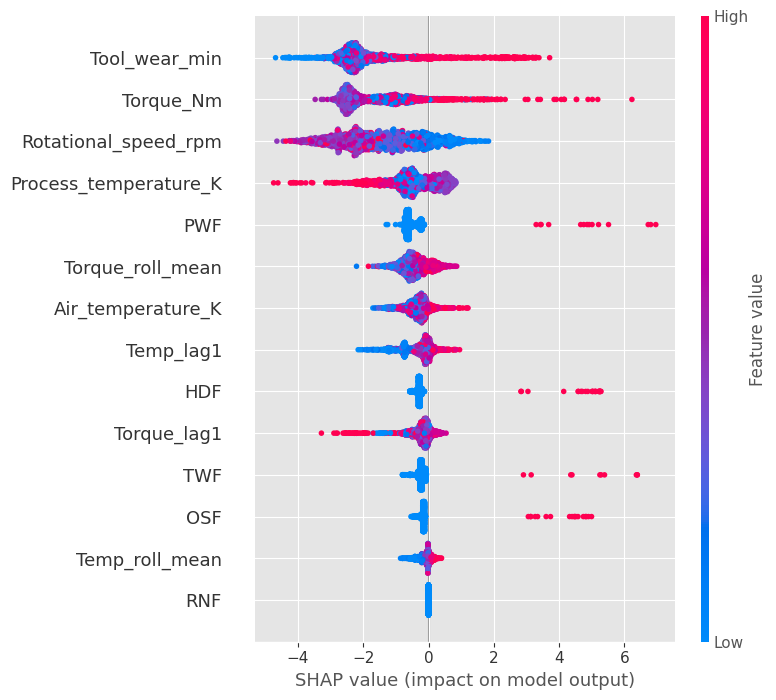

In [101]:
explainer = shap.Explainer(xgb)      #shap tells WHY did the model say failure?”
shap_values = explainer(X_test_processed_cleaned)

shap.summary_plot(shap_values, X_test_processed_cleaned)

In [102]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1838  102]
 [   2   58]]


In [103]:
# RUC-AUC Score
from sklearn.metrics import roc_auc_score

y_prob = xgb.predict_proba(X_test_processed_cleaned)[:,1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ROC-AUC Score: 0.9882731958762887


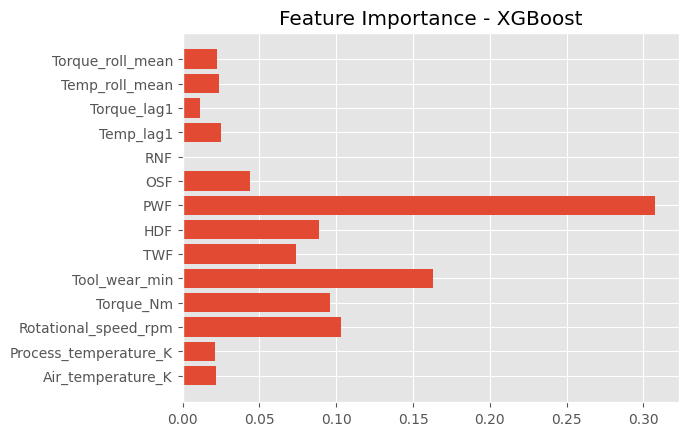

In [104]:
import matplotlib.pyplot as plt

plt.barh(X_test_processed_cleaned.columns, xgb.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.show()

Random Forest (trained with class_weight='balanced' and SMOTE on training data):

Precision (Failure): 0.51
Recall (Failure): 0.97
F1-Score (Failure): 0.67
ROC-AUC: 0.980
Optimized XGBoost (trained with SMOTE on training data and scale_pos_weight=10):

Precision (Failure): 0.45 (from random_search.best_estimator_ results)
Recall (Failure): 0.97
F1-Score (Failure): 0.61
ROC-AUC: 0.9895
XGBoost (manual parameters, trained with SMOTE on training data and scale_pos_weight=len(y_train)/max(y_train.sum(), 1)):

Precision (Failure): 0.47
Recall (Failure): 0.97
F1-Score (Failure): 0.63
ROC-AUC: 0.9887
Analysis:

Precision for 'Failure': You're right that the Random Forest model shows slightly higher precision for detecting failures (0.51) compared to the XGBoost models (0.45-0.47). This means that when Random Forest predicts a failure, it's slightly more likely to be a true failure.

Recall for 'Failure': All models perform exceptionally well on recall for the 'Failure' class (0.97). This is highly critical for your objective of "detecting potential failure 24 hours in advance to reduce downtime cost." High recall means the model is excellent at identifying most actual machine failures, minimizing false negatives (missed failures).

ROC-AUC Score: Both XGBoost models achieve a slightly higher ROC-AUC score (around 0.989) than the Random Forest model (0.980). ROC-AUC provides a good overall measure of a classifier's performance across all possible classification thresholds, which is particularly useful for imbalanced datasets.

Conclusion:

While Random Forest has a slightly better precision, both XGBoost models demonstrate a slightly better overall performance as indicated by their higher ROC-AUC. More importantly, all models achieve excellent recall (0.97) for the 'Failure' class, which is paramount for a predictive maintenance system where missing a failure (false negative) can be very costly.

The choice between them depends on the specific business impact of false positives versus false negatives:

In [105]:
## Data Leakage Check

# - Train-test split performed before training
# - SMOTE applied only on training data
# - No future information used in feature engineering

In [106]:
### Week 2 Insights

# - SMOTE helped balance the dataset and improved recall
# - XGBoost performed better than Random Forest baseline
# - SHAP showed that temperature, torque, and tool wear strongly influence failure
# - Model can be used for predictive maintenance in factories

In [107]:
# 2.preprocessing

***MODELLING***

In [108]:
import json

# Data (X_train, X_test, y_train, y_test) is already loaded and split from previous cells
# We will use the already processed X_train and X_test for feature columns
feature_cols = [
    'Air_temperature_K',
    'Process_temperature_K',
    'Rotational_speed_rpm',
    'Torque_Nm',
    'Tool_wear_min',
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF',
    'Temp_lag1',
    'Torque_lag1',
    'Temp_roll_mean',
    'Torque_roll_mean'
]

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Train positive rate:", y_train.mean()*100, "%")
print("Test positive rate:", y_test.mean()*100, "%")

Train: (7998, 17) (7998,)
Test: (2000, 17) (2000,)
Train positive rate: 3.488372093023256 %
Test positive rate: 3.0 %


In [109]:

# Fix y_train if needed (pandas read_csv behavior)
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [110]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote_processed, y_train)

print("After SMOTE:")
print(f"  Train samples: {len(X_train_smote)}")
print(f"  Positive rate: {y_train_smote.mean()*100:.1f}%")

After SMOTE:
  Train samples: 15438
  Positive rate: 50.0%


In [111]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_smote, y_train_smote)

# Ensure X_test has the same features as X_train_smote
# X_test_processed was already created by dropping 'UDI', 'Product ID', 'Type'
y_pred_log = log_model.predict(X_test_processed)
y_prob_log = log_model.predict_proba(X_test_processed)[:,1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1940
           1       0.32      0.97      0.48        60

    accuracy                           0.94      2000
   macro avg       0.66      0.95      0.72      2000
weighted avg       0.98      0.94      0.95      2000

ROC-AUC: 0.9852147766323024


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
# Random forest

In [113]:

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.97      0.98      1940
     Failure       0.51      0.97      0.67        60

    accuracy                           0.97      2000
   macro avg       0.75      0.97      0.83      2000
weighted avg       0.98      0.97      0.98      2000


Confusion Matrix:
[[1884   56]
 [   2   58]]

ROC-AUC: 0.9800515463917525


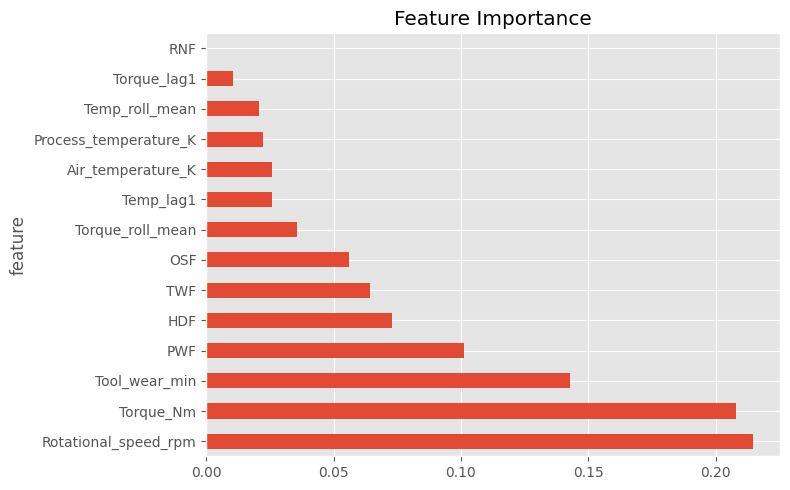

In [114]:
# Feature importance
imp = pd.DataFrame({'feature': feature_cols, 'importance': model.feature_importances_})
imp = imp.sort_values('importance', ascending=False)
imp.plot(x='feature', y='importance', kind='barh', figsize=(8, 5), legend=False)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


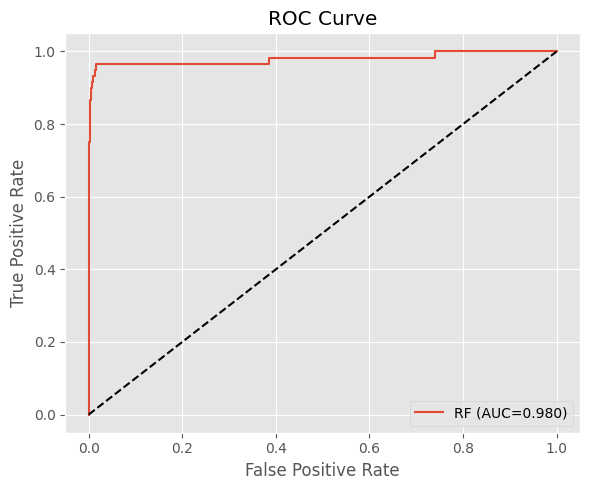

In [115]:
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'RF (AUC={roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
#XGBoost
try:
    import xgboost as xgb
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=len(y_train)/max(y_train.sum(), 1), random_state=42)
    # Fit the model using the cleaned SMOTE-resampled training data
    xgb_model.fit(X_res_cleaned, y_train_smote)
    # Make predictions using the cleaned processed test data
    y_pred_xgb = xgb_model.predict(X_test_processed_cleaned)
    print("XGBoost Classification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['No Failure', 'Failure']))
    print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test_processed_cleaned)[:, 1]))
except ImportError:
    print("XGBoost not installed. pip install xgboost")

XGBoost Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.97      0.98      1940
     Failure       0.47      0.97      0.63        60

    accuracy                           0.97      2000
   macro avg       0.74      0.97      0.81      2000
weighted avg       0.98      0.97      0.97      2000

ROC-AUC: 0.9887886597938144


In [117]:
from pathlib import Path
import joblib

# Save best model
Path('models').mkdir(exist_ok=True)
joblib.dump(model, 'models/rf_model.joblib')
print("Model saved to models/rf_model.joblib")

Model saved to models/rf_model.joblib


### Verifying the Saved Model

Let's load the `rf_model.joblib` file to ensure it was saved correctly and to confirm its type and functionality.

In [118]:
import joblib

# Path to the saved model
model_path = 'models/rf_model.joblib'

# Load the model
loaded_rf_model = joblib.load(model_path)

print(f"Successfully loaded model from: {model_path}")
print(f"Type of loaded object: {type(loaded_rf_model)}")

# You can also check some properties of the loaded model, e.g., number of estimators
print(f"Number of estimators in loaded model: {loaded_rf_model.n_estimators}")

# Make a prediction on a sample from the test set (e.g., the first instance)
# Ensure X_test_processed is available and has the same feature structure as during training
if 'X_test_processed' in globals():
    sample_X = X_test_processed.iloc[[0]] # Get the first sample as a DataFrame
    prediction = loaded_rf_model.predict(sample_X)
    prediction_proba = loaded_rf_model.predict_proba(sample_X)

    print(f"\nPrediction for the first test sample: {prediction[0]} (0=No Failure, 1=Failure)")
    print(f"Prediction probabilities: No Failure={prediction_proba[0][0]:.4f}, Failure={prediction_proba[0][1]:.4f}")
else:
    print("\nX_test_processed is not defined. Cannot make a sample prediction.")

Successfully loaded model from: models/rf_model.joblib
Type of loaded object: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Number of estimators in loaded model: 100

Prediction for the first test sample: 0 (0=No Failure, 1=Failure)
Prediction probabilities: No Failure=0.7086, Failure=0.2914


In [119]:
#RandomizedSearchCV


from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Clean column names for X_train_smote before fitting
X_train_smote_cleaned = clean_col_names(X_train_smote.copy())

random_search.fit(X_train_smote_cleaned, y_train_smote)

best_model = random_search.best_estimator_

print("Best Params:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05}


In [120]:
import os

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# Change to the root directory (if not already there)
# This is often '/content' in Colab or '/content/Infotech' if you cd'd into it
# For this project, the model was saved relative to '/content/Infotech'
# So, let's navigate to '/content/Infotech' first if we are not there.
# The `os.chdir()` command changes the current directory.

# First, check if the 'models' directory exists in the current directory
if os.path.exists('models'):
    print("\n'models' directory found in current working directory.")
else:
    # If not, let's try navigating to '/content/Infotech' and checking there
    try:
        os.chdir('/content/Infotech')
        print("\nChanged directory to /content/Infotech")
        current_directory = os.getcwd()
        print(f"New current working directory: {current_directory}")
    except FileNotFoundError:
        print("\nCould not change to /content/Infotech. Please check your current path.")

# Now, list the contents of the 'models' directory
models_path = os.path.join(current_directory, 'models')
if os.path.exists(models_path):
    print(f"\nContents of '{models_path}':")
    for item in os.listdir(models_path):
        print(item)
else:
    print(f"\nDirectory '{models_path}' does not exist. The model might not have been saved successfully or at this location.")

Current working directory: /content/Infotech/Infotech/Infotech

'models' directory found in current working directory.

Contents of '/content/Infotech/Infotech/Infotech/models':
rf_model.joblib


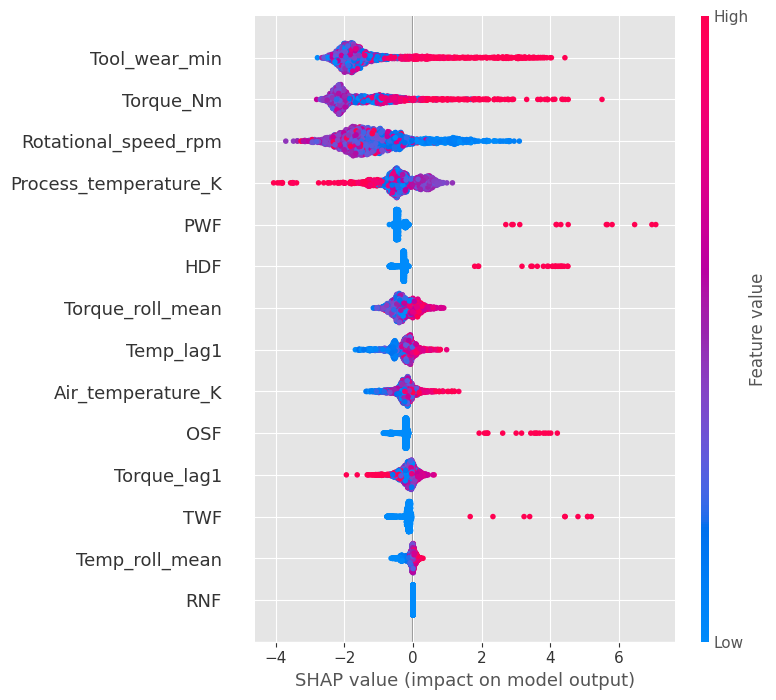

In [121]:
import shap #tells why this model failed?

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_processed_cleaned)

shap.summary_plot(shap_values, X_test_processed_cleaned)